In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping

### Read in the nutritional info metadata and define the columns. Select only those rows in the metadata for which there are images available. 

In [2]:
# Define file paths for metadata and imagery folders
metadata_folder = 'nutrition5k_dataset/metadata/'
imagery_folder = 'nutrition5k_dataset/imagery/realsense_overhead/'

# Load metadata CSV files
metadata_cafe1 = pd.read_csv(os.path.join(metadata_folder, 'dish_metadata_cafe1.csv'), on_bad_lines='skip', header=None)
metadata_cafe2 = pd.read_csv(os.path.join(metadata_folder, 'dish_metadata_cafe2.csv'), on_bad_lines='skip', header=None)

# Combine both metadata files into one DataFrame
metadata = pd.concat([metadata_cafe1, metadata_cafe2], ignore_index=True)

# Display the first few rows to inspect the structure
display(metadata.head())

# Now, we know that the first column (column 0) is 'dish_id'
# Let's ensure it's a string, so we can match it to the image paths
metadata[0] = metadata[0].astype(str)

# Function to check if an image exists for a given dish_id.  Some dish_id have no associated imagery.
def image_exists(dish_id):
    image_path = os.path.join(imagery_folder, f'{dish_id}/rgb.png')
    return os.path.exists(image_path)

# Filter the metadata to retain only rows with a corresponding image
metadata_with_images = metadata[metadata[0].apply(image_exists)]

# Display the number of rows before and after filtering
display(f"Total rows in the metadata before filtering: {len(metadata)}")
display(f"Total rows in metadata after eliminating those without associated images: {len(metadata_with_images)}")
print("\n")

# Optionally, save the filtered metadata if needed
# metadata_with_images.to_csv('filtered_metadata.csv', index=False)

# Display the first few rows of the filtered metadata
print("First few rows of the combined metadata file, where there is a plate image corresponding to the dish_id.")
display(metadata_with_images.head())

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,dish_1561662216,300.794281,193.0,12.387489,28.218290,18.633970,ingr_0000000508,soy sauce,3.398568,1.801241,...,0.000425,0.019754,0.004248,ingr_0000000513,millet,3.414345,4.063071,0.034143,0.80920,0.119502
1,dish_1562688426,137.569992,88.0,8.256000,5.190000,10.297000,ingr_0000000433,roasted potatoes,17.000000,23.970000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,dish_1561662054,419.438782,292.0,23.838249,26.351543,25.910593,ingr_0000000312,pepper,0.300716,0.120286,...,0.000000,0.000000,0.000000,ingr_0000000524,parsley,0.752816,0.279295,0.006023,0.04818,0.021832
3,dish_1562008979,382.936646,290.0,22.224644,10.173570,35.345387,ingr_0000000448,jalapenos,0.192961,0.055959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,dish_1560455030,20.590000,103.0,0.148000,4.625000,0.956000,ingr_0000000471,cherry tomatoes,55.000000,9.900000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'Total rows in the metadata before filtering: 4583'

'Total rows in metadata after eliminating those without associated images: 3079'



First few rows of the combined metadata file, where there is a plate image corresponding to the dish_id.


,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,dish_1561662216,300.794281,193.0,12.387489,28.218290,18.633970,ingr_0000000508,soy sauce,3.398568,1.801241,...,0.000425,0.019754,0.004248,ingr_0000000513,millet,3.414345,4.063071,0.034143,0.80920,0.119502
2,dish_1561662054,419.438782,292.0,23.838249,26.351543,25.910593,ingr_0000000312,pepper,0.300716,0.120286,...,0.000000,0.000000,0.000000,ingr_0000000524,parsley,0.752816,0.279295,0.006023,0.04818,0.021832
3,dish_1562008979,382.936646,290.0,22.224644,10.173570,35.345387,ingr_0000000448,jalapenos,0.192961,0.055959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,dish_1560455030,20.590000,103.0,0.148000,4.625000,0.956000,ingr_0000000471,cherry tomatoes,55.000000,9.900000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,dish_1558372433,74.360001,143.0,0.286000,0.429000,20.020000,ingr_0000000453,deprecated,143.000000,74.360000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Obtain each image from the dataset folder, resize, normalize. OHE encode the image labels.

In [3]:
# Set folder path for images
image_folder = 'nutrition5k_dataset/imagery/realsense_overhead/'

# Image size for resizing
image_size = (224, 224)

# Lists to store images and labels
images = []
dish_ids = []

# Loop through each row in the metadata
for index, row in metadata.iterrows():
    # Since 'dish_id' is in the first column (column 0), we use row[0] instead of row['dish_id']
    dish_id = row[0]  # Accessing the first column of the row (which contains 'dish_id')
    
    # Construct the image path
    image_path = os.path.join(image_folder, dish_id, 'rgb.png')
    
    # Check if the image exists
    if os.path.exists(image_path):
        # Load the image
        image = cv2.imread(image_path)
        
        # Resize the image to a consistent size
        image = cv2.resize(image, image_size)
        
        # Convert the image to an array
        image = img_to_array(image)
        
        # Append the image and dish_id to the respective lists
        images.append(image)
        dish_ids.append(dish_id)

# Convert the lists to numpy arrays
images = np.array(images, dtype="float32") / 255.0  # Normalize pixel values to [0, 1]
dish_ids = np.array(dish_ids)

# Convert dish_ids to categorical labels
dish_id_labels = pd.Categorical(dish_ids).codes  # Convert dish_ids to numerical labels
dish_id_labels = to_categorical(dish_id_labels)  # One-hot encode the labels
num_dishes = dish_id_labels.shape[1]             # Determine the number of ingredients in each row

# Print the shapes of the resulting arrays
print(f"Images shape: {images.shape}")
print(f"Dish ID labels shape: {dish_id_labels.shape}")

Images shape: (3079, 224, 224, 3)
Dish ID labels shape: (3079, 3079)


### Train-test split.

In [4]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, dish_id_labels, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2463, 224, 224, 3)
(2463, 3079)
(616, 224, 224, 3)
(616, 3079)


### Model definition. Use data augmentation, Import base_model and set freezing layer. Customize Dense layers. Print number of model layers.

In [13]:
#from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.activations import hard_silu

# Create an instance of ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)

# Load pre-trained model without the top layer
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Set the number of layers for which the ImageNet weights will be preserved:
freeze_layer = 170
for layer in base_model.layers[:freeze_layer]:
    layer.trainable = False

# Set the rest of the layers to be fine-tuned on the training set.
for layer in base_model.layers[freeze_layer:]:
    layer.trainable = True

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(2048, activation='hard_silu')(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation='hard_silu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='hard_silu')(x)
#x = Dropout(0.3)(x)
x = Dense(256, activation='hard_silu')(x)
#x = Dropout(0.6)(x)
x = Dense(num_dishes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)
print(f"The model has {len(model.layers)} layers total, of which {len(base_model.layers)} comes from the base_model.")

The model has 197 layers total, of which 187 comes from the base_model.


### Set optimizer, LR, loss and metrics hyperparameters. Train the model.

In [14]:
# Compile and train the model
optimizer = AdamW(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(train_generator, validation_data=(X_test, y_test), epochs=50)

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 214ms/step - accuracy: 0.0000e+00 - loss: 8.1045 - val_accuracy: 0.0000e+00 - val_loss: 8.0926
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 209ms/step - accuracy: 0.0000e+00 - loss: 8.0904 - val_accuracy: 0.0000e+00 - val_loss: 8.9693
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 8.0609e-04 - loss: 7.8437 - val_accuracy: 0.0000e+00 - val_loss: 8.9539
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/step - accuracy: 0.0000e+00 - loss: 7.6884 - val_accuracy: 0.0000e+00 - val_loss: 9.0589
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 0.0015 - loss: 7.5817 - val_accuracy: 0.0000e+00 - val_loss: 9.6405
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 214ms/step - accuracy: 2.7536e-04 - loss: 7.4297 - val_accuracy: 0.0000e+00 - val_loss: 9.8904
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 216ms/step - accuracy: 0.0016 - loss: 7.3752 - val_accuracy: 0.0000e+00 - val_loss: 10.1196
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 212ms/

### Plot training and validation accuracy and loss.

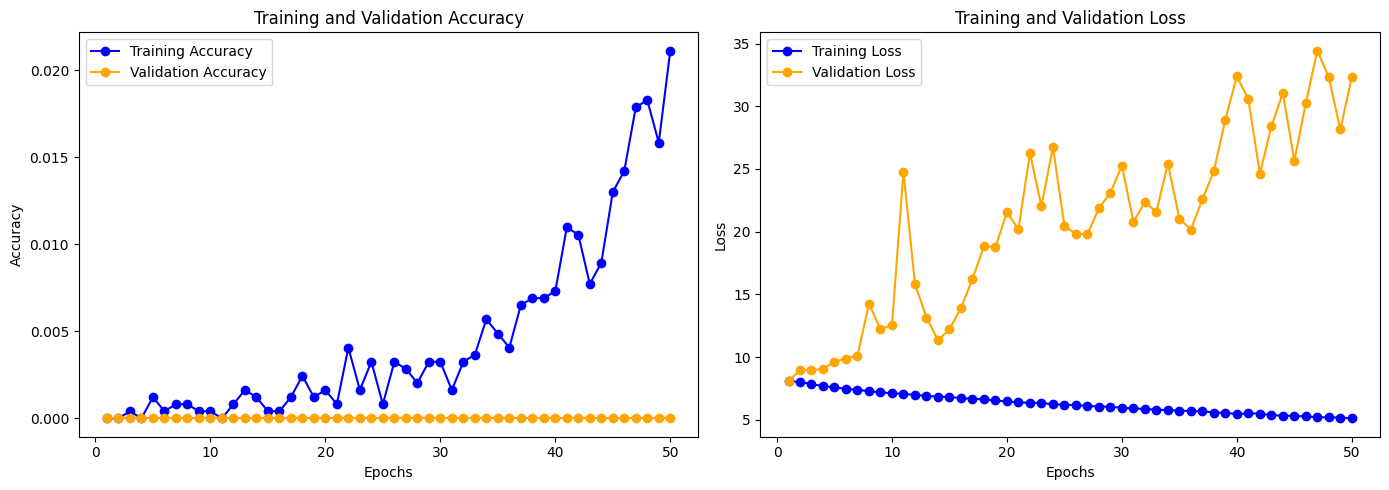

In [15]:
# Get training and validation accuracy/loss from the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(1, len(accuracy) + 1)

# Plot training and validation accuracy and loss side-by-side
plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')  # Blue for training accuracy
plt.plot(epochs, val_accuracy, 'o-', color='orange', label='Validation Accuracy')  # Orange for validation accuracy
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')  # Blue for training loss
plt.plot(epochs, val_loss, 'o-', color='orange', label='Validation Loss')  # Orange for validation loss
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Automatically adjust layout to fit everything
plt.tight_layout()

# Show the plots
plt.show()

### Define functions to get glycemic index data from glycemic_index.xlsx; from the prediction, get nutritional info; display nutritional information.

In [20]:
import cv2
import pandas as pd

# Load the glycemic index data from the Excel file (this assumes glycemic_index.xlsx exists)
gi_data = pd.read_excel("glycemic_index.xlsx")

# Create a dictionary from the Excel file for quick lookup
gi_dict = pd.Series(gi_data['Glycemic index'].values, index=gi_data['Item']).to_dict()

# Predict dish_id from an image
def predict_dish(image):
    image = cv2.resize(image, image_size)  # Resize to match the input shape
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = image.astype("float32") / 255.0  # Normalize

    # Predict dish ID
    prediction = model.predict(image)
    dish_index = np.argmax(prediction)  # Get the predicted dish index
    predicted_dish_id = pd.Categorical(dish_ids).categories[dish_index]
    
    # Retrieve nutritional info based on predicted dish_id
    nutrition_info = metadata[metadata[0] == predicted_dish_id]

    if nutrition_info.empty:
        return predicted_dish_id, None  # Return None if no matching dish_id is found

    return predicted_dish_id, nutrition_info.iloc[0]

# Function to get glycemic index from the Excel data
def get_glycemic_index(ingredient):
    # Normalize ingredient names for case-insensitive matching
    ingredient_lower = ingredient.lower()
    gi_dict_lower = {k.lower(): v for k, v in gi_dict.items()}

    # Return the glycemic index if present in the Excel data
    if ingredient_lower in gi_dict_lower:
        return gi_dict_lower[ingredient_lower]
    else:
        return "GI not available"

# Function to calculate the weighted glycemic index for the entire dish
def calculate_weighted_gi(ingredients_info):
    total_weight = 0  # Sum of all ingredient masses
    weighted_sum_gi = 0  # To accumulate the weighted sum of GIs

    # Loop through each ingredient information tuple (ID, Name, Mass, Calories, Fat, Carbs, Protein)
    for ingredient_info in ingredients_info:
        ingredient_name = ingredient_info[1]
        ingredient_mass = ingredient_info[2]
        
        # Get the glycemic index for the ingredient
        gi_value = get_glycemic_index(ingredient_name)
        
        # If GI is available and valid, add to the weighted sum
        if isinstance(gi_value, (int, float)):
            weighted_sum_gi += gi_value * ingredient_mass
            total_weight += ingredient_mass
        else:
            print(f"Warning: {gi_value} for {ingredient_name}")

    # Calculate the weighted average GI
    if total_weight > 0:
        weighted_avg_gi = weighted_sum_gi / total_weight
        return weighted_avg_gi
    else:
        return "Total weight is zero, cannot calculate weighted average."

# Function to display nutritional info and calculate GI
def display_nutrition_info(nutrition_info):

    column_names = [
        'Dish ID', 'Total Calories', 'Total Mass', 'Total Fat', 'Total Carbohydrates', 'Total Protein'
    ]
    
    # Display basic nutritional info
    print("=== Dish Nutritional Information ===")
    for i, column in enumerate(column_names):
        print(f"{column}: {nutrition_info[i]}")

    # Display ingredients and their nutritional info
    print("\n=== Ingredients Information ===")
    ingredient_offset = 6  # Ingredients start from the 7th column (index 6)
    ingredient_number = 1
    ingredients_info = []  # To store ingredient information for GI calculation

    while ingredient_offset < len(nutrition_info):
        # Check if the ingredient name is NaN, which indicates no more ingredients
        if pd.isna(nutrition_info[ingredient_offset + 1]):
            break
        
        # Extract ingredient information
        ingredient_id = nutrition_info[ingredient_offset]
        ingredient_name = nutrition_info[ingredient_offset + 1]
        ingredient_mass = nutrition_info[ingredient_offset + 2]
        ingredient_calories = nutrition_info[ingredient_offset + 3]
        ingredient_fat = nutrition_info[ingredient_offset + 4]
        ingredient_carbs = nutrition_info[ingredient_offset + 5]
        ingredient_protein = nutrition_info[ingredient_offset + 6]

        print(f"\nIngredient {ingredient_number}:")
        print(f"  Ingredient ID: {ingredient_id}")
        print(f"  Ingredient Name: {ingredient_name}")
        print(f"  Ingredient Grams: {ingredient_mass}")
        print(f"  Ingredient Calories: {ingredient_calories}")
        print(f"  Ingredient Fat: {ingredient_fat}")
        print(f"  Ingredient Carbohydrates: {ingredient_carbs}")
        print(f"  Ingredient Protein: {ingredient_protein}")

        # Get the glycemic index for this ingredient
        gi_value = get_glycemic_index(ingredient_name)
        print(f"  Glycemic Index: {gi_value}")

        # Store ingredient info for weighted GI calculation
        ingredients_info.append((
            ingredient_id, ingredient_name, ingredient_mass, ingredient_calories, ingredient_fat, ingredient_carbs, ingredient_protein
        ))

        # Move to the next ingredient (each ingredient has 7 columns)
        ingredient_offset += 7
        ingredient_number += 1

    # Calculate and display the weighted average glycemic index for the dish
    weighted_avg_gi = calculate_weighted_gi(ingredients_info)
    print(f"\nThe Weighted Average Glycemic Index for the entire dish is: {weighted_avg_gi}")

# Main function to process an image and predict the nutritional info
def process_dish_image(img_path):
    img = cv2.imread(img_path)
    
    # Plot the image
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6)) 
    plt.imshow(img_rgb)
    plt.title("Plate of food to be predicted on")  
    plt.axis('off')  
    plt.show()

    # Predict the dish ID and nutrition info using the model
    dish_id, nutrition_info = predict_dish(img) 

    # Output the predicted dish ID
    print(f"Predicted Dish ID: {dish_id}")
    
    # Display the nutritional information and calculate GI
    display_nutrition_info(nutrition_info)

### Make a prediction on an image in the dataset.

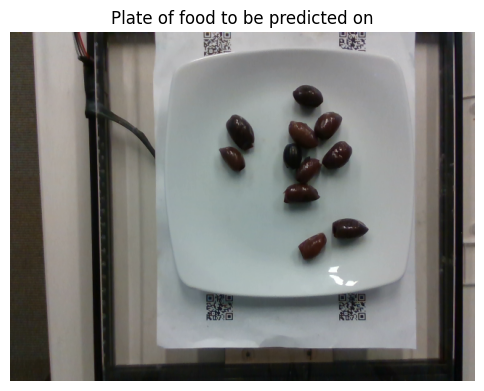

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Dish ID: dish_1558381084
=== Dish Nutritional Information ===
Dish ID: dish_1558381084
Total Calories: 36.57
Total Mass: 53.0
Total Fat: 0.106
Total Carbohydrates: 9.54
Total Protein: 0.371

=== Ingredients Information ===

Ingredient 1:
  Ingredient ID: ingr_0000000440
  Ingredient Name: grapes
  Ingredient Grams: 53.0
  Ingredient Calories: 36.57
  Ingredient Fat: 0.106
  Ingredient Carbohydrates: 9.54
  Ingredient Protein: 0.371
  Glycemic Index: 56.0

The Weighted Average Glycemic Index for the entire dish is: 56.0


In [21]:
# Select an image from the realsense_overhead folder and make a prediction.
img_path = 'nutrition5k_dataset/imagery/realsense_overhead/dish_1556572657/rgb.png'
process_dish_image(img_path)

### This code was just used to print all the ingredients in the dataset.  Ignore.

In [70]:
# Initialize a set to store unique ingredient names (to avoid duplicates)
unique_ingredients = set()

# Ingredients start at column 7 (ingredient 1 name), and each ingredient block has 7 columns
ingredient_name_col_start = 7
num_columns = metadata.shape[1]  # Number of columns in the metadata

# Loop over each row in the existing metadata DataFrame
for _, row in metadata.iterrows():
    # Iterate through the ingredient columns, stepping by 7 columns (each ingredient block)
    for col in range(ingredient_name_col_start, num_columns, 7):
        ingredient_name = row[col]  # This is the ingredient name

        # Check if the ingredient name is valid (not NaN or empty)
        if pd.notna(ingredient_name) and ingredient_name != '':
            unique_ingredients.add(ingredient_name)

# Convert the set to a sorted list for better readability
sorted_ingredients = sorted(unique_ingredients)

# Print all the unique ingredients
print("List of unique ingredients in the metadata:")
# for ingredient in sorted_ingredients:
#    print(ingredient)

List of unique ingredients in the metadata:
